# Modificação do código de 100% de acurácia

O código abaixo foi feito seguindo o modelo proposto em https://www.kaggle.com/code/muki2003/count-finger-accurancy-100/notebook

In [3]:
pip install opendatasets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import os
import random
import matplotlib.pyplot as plt

In [4]:
import opendatasets as od

In [89]:
od.download("https://www.kaggle.com/datasets/koryakinp/fingers")

Skipping, found downloaded files in "./fingers" (use force=True to force download)


In [90]:
trainpath = os.listdir("fingers/train")
testpath = os.listdir("fingers/test")

In [69]:
# Amostragem do dataset em 10%
# trainpath = trainpath[ :int(len(trainpath) * 0.1) ]
# testpath = testpath[ :int(len(testpath) * 0.1) ]

In [91]:
traindata = ['fingers/train/' + i for i in trainpath]
testdata = ["fingers/test/" + i for i in testpath]

- Visualização do tamanho dos conjuntos de treino e teste

In [92]:
print("Tamanho treinamento:", len(traindata))
print("Tamanho teste:", len(testdata))

Tamanho treinamento: 18000
Tamanho teste: 3600


- Criação dos DataFrames de treino e teste com a coluna Filepath, que representa a imagem

In [93]:
traindata = pd.DataFrame(traindata, columns=['Filepath'])
testdata = pd.DataFrame(testdata, columns=['Filepath'])

- Adição da coluna target aos DataFrames de treino e teste, que contém os labels das imagens, que nesse caso representa o número de dedos da imagem correspondente

In [94]:
traindata['target'] = traindata['Filepath'].apply(lambda a: a[-6:-5])
testdata['target'] = testdata['Filepath'].apply(lambda a: a[-6:-5])

- Visualização do conjunto de treino

In [95]:
traindata

,Filepath,target
0,fingers/train/a8eb25cf-8f87-44f3-831b-7d7cf2db...,2
1,fingers/train/7f8b62a5-ebd4-4288-a29f-5396d052...,0
2,fingers/train/2c6c55d6-82dc-4277-bbf6-9f65be19...,5
3,fingers/train/2053a44d-39f8-4d5d-98c9-4270db1a...,1
4,fingers/train/e264adab-9188-4ff8-b5e2-58bafcde...,5
...,...,...
17995,fingers/train/71e6fbde-b41d-4454-9c3a-64b3938e...,1
17996,fingers/train/c4565914-ebed-42d3-959b-edcd6ac4...,1
17997,fingers/train/85d68a3a-84fc-4ebf-a1a2-f23f8b9b...,5
17998,fingers/train/45795156-6886-43b8-9dd5-a6f636ba...,1


- Pré-processamento, como normalização de pixels e dimensionamento, para garantir que as imagens estejam no formato esperado pelo modelo. Além disso, estamos dividindo o conjunto de dados em 90% para treinamento e 10% para validação.

In [96]:
ds_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,validation_split=0.2)

- Criação de geradores de dados de imagem para treinamento, validação e teste, e especificação de várias configurações, como tamanho do lote, tamanho da imagem e modo de cor

In [97]:
# informa imagens, labels, faz o redimensionamento das imagens
train_ds = ds_generator.flow_from_dataframe(dataframe=traindata,x_col='Filepath',y_col='target',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=16,subset='training')
val_ds = ds_generator.flow_from_dataframe(dataframe=traindata,x_col='Filepath',y_col='target',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=16,subset='validation')
test_ds = ds_generator.flow_from_dataframe(dataframe=testdata,x_col='Filepath',y_col='target',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=16)

Found 14400 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.


- Biblioteca para o modelo utilizado: EfficienteNet, na versão B0

In [98]:
from tensorflow.keras.applications import EfficientNetB0  # Use a versão B0


- Criação do modelo EfficientNetB0 pré-treinado com pesos do ImageNet e congelamento todas as suas camadas para que não sejam atualizadas durante o treinamento

In [99]:
num_classes = 6  # Número de classes para a sua tarefa
efficientnet = EfficientNetB0(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
# Congelar as camadas do modelo base
for layer in efficientnet.layers:
    layer.trainable = False

- Adição de camadas adicionais ao final do EfficientNet para personalizar o modelo de acordo com a sua tarefa específica de classificação de imagens de mãos. Essas camadas adicionais ajudam a extrair características mais específicas.

In [100]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Adicionando Global Average Pooling ao final do EfficientNet
x = GlobalAveragePooling2D()(efficientnet.output)

# Adicionando uma camada Dense com ativação softmax para a saída do modelo
output = Dense(num_classes, activation='softmax')(x)

# Adicionando camadas Dense adicionais
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Conectando a saída das camadas Dense adicionais à saída do modelo
output = Dense(num_classes, activation='softmax')(x)

# Criando o modelo final com entrada do EfficientNet e saída personalizada
model = Model(inputs=efficientnet.input, outputs=output)

- Compilação do modelo e treino.

In [101]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=3)

Epoch 1/3
900/900 [==============================] - 1142s 1s/step - loss: 0.0567 - accuracy: 0.9842 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/3
900/900 [==============================] - 1075s 1s/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 1.9660e-04 - val_accuracy: 1.0000
Epoch 3/3
900/900 [==============================] - 1117s 1s/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 1.1484e-04 - val_accuracy: 1.0000


# Bloco de execuções
Foram executadas 8 iterações:

## Primeira Execução

- Tempo de execução: 4 minutos e 52 segundos
- Tamanho: 10% do dataset
- Tamanho do conjunto de validação: 10%
- Duas camadas adicionais (64 neurônios e 32 neurônios)
- Congelando a atualização das camadas

### Epoch 1:


#### Treino:


- Loss: 0.3966
- Accuracy: 0.8926


#### Validação:


- Loss: 0.8926
- Accuracy: 1.0

### Epoch 2:


#### Treino:


- Loss: 0.0465
- Accuracy: 0.9938


#### Validação:


- Loss: 0.0123
- Accuracy: 1.0

## Segunda execução:

- Tempo de execução: 36 minutos e 56 segundos
- Tamanho: Todo o dataset
- Tamanho do conjunto de validação: 10%
- Duas camadas adicionais (64 neurônios e 32 neurônios)
- Congelando a atualização das camadas


### Epoch 1

#### Treino

- Loss: 0.0631
- Accuracy: 0.9827

#### Validação


- Loss: 0.0010
- Accuracy: 1.0

### Epoch 2

#### Treino


- Loss: 0.0045
- Accuracy: 0.9986

#### Validação

- Loss: 5.3764e-04
- Accuracy: 1.0

## Terceira Execução

- Tempo de execução: 4 minutos e 31 segundos
- Tamanho: 10% do dataset
- Tamanho do conjunto de validação: 20%
- Uma camada adicional (64 neurônios)
- Congelando a atualização das camadas

### Epoch 1

#### Treino

- Loss: 0.3862
- Accuracy: 0.8868


#### Validação

- Loss: 0.0817
- Accuracy: 0.9833


### Epoch 2

#### Treino

- Loss: 0.0716
- Accuracy: 0.9917

#### Validação

- Loss: 0.0497
- Accuracy: 0.9944


## Quarta execução

- Tempo de execução: 4 minutos e 31 segundos
- Tamanho: 10% do dataset
- Tamanho do conjunto de validação: 20%
- Duas camadas adicionais (64 neurônios e 64 neurônios)
- Congelando a atualização das camadas

### Epoch 1

#### Treino

- Loss: 0.4206
- Accuracy: 0.8896


#### Teste

- Loss: 0.0499
- Accuracy: 0.9972




### Epoch 2

#### Treino

- Loss: 0.0507
- Accuracy: 0.9917


#### Teste

- Loss: 0.0220
- Accuracy: 0.9944



## Quinta execução

- Tempo de execução: 6 minutos e 33 segundos
- Tamanho: 10% do dataset
- Tamanho do conjunto de validação: 20%
- Duas camadas adicionais (64 neurônios e 64 neurônios)
- Congelando a atualização das camadas

### Epoch 1

#### Treino

- Loss: 0.0349
- Accuracy: 0.9931


#### Teste

- Loss: 0.0090
- Accuracy: 1.0


### Epoch 2

#### Treino

- Loss: 0.0187
- Accuracy: 0.9931


#### Teste

- Loss: 0.0025
- Accuracy: 1.0



### Epoch 3

#### Treino


- Loss: 0.0158
- Accuracy: 0.9937

#### Teste

- Loss: 0.0163
- Accuracy: 0.9917

## Sexta execução

- Tempo de execução: 6 minutos e 35 segundos
- Tamanho: 10% do dataset
- Tamanho do conjunto de validação: 20%
- Sem camadas adicionais
- Congelando a atualização das camadas

### Epoch 1

#### Treino

- Loss: 0.6739
- Accuracy: 0.8597


#### Teste

- Loss: 0.2538
- Accuracy: 0.9861


### Epoch 2

#### Treino

- Loss: 0.2216
- Accuracy: 0.9778


#### Teste

- Loss: 0.1358
- Accuracy: 0.9889





### Epoch 3

#### Treino


- Loss: 0.1432
- Accuracy: 0.9847


#### Teste

- Loss: 0.0893
- Accuracy: 0.9972


## Sétima execução

- Tempo de execução: 20 minutos e 54 segundos
- Tamanho: 10% do dataset
- Tamanho do conjunto de validação: 20%
- Sem camadas adicionais
- Permitindo a atualização das camadas

### Epoch 1

#### Treino

- Loss: 0.2445
- Accuracy: 0.9201



#### Teste

- Loss: 0.1824
- Accuracy: 0.9306



### Epoch 2

#### Treino

- Loss: 0.0547
- Accuracy: 0.9819


#### Teste

- Loss: 0.0353
- Accuracy: 0.9861




### Epoch 3

#### Treino


- Loss: 0.0160
- Accuracy: 0.9944


#### Teste

- Loss: 0.0382
- Accuracy: 0.9861


## Oitava execução

- Tempo de execução: 56 minutos e 19 segundos
- Tamanho: Todo o dataset
- Tamanho do conjunto de validação: 20%
- Duas camadas adicionais (64 neurônios e 64 neurônios)
- Congelando a atualização das camadas

### Epoch 1

#### Treino

- Loss: 0.0567
- Accuracy: 0.9842



#### Teste

- Loss: 0.0014
- Accuracy: 1.0



### Epoch 2

#### Treino

- Loss: 0.0071
- Accuracy: 0.9982



#### Teste

- Loss: 1.9660e-04
- Accuracy: 1.0


### Epoch 3

#### Treino


- Loss: 0.0071
- Accuracy: 0.9976


#### Teste

- Loss: 1.1484e-04
- Accuracy: 1.0

# Sumário do modelo

In [102]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_8[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_9 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_4[0][0]'

# Conjunto de teste

- Referente a última iteração

In [103]:
loss, acc = model.evaluate(test_ds)

225/225 [==============================] - 212s 938ms/step - loss: 1.6706e-04 - accuracy: 1.0000


- Loss

In [107]:
loss

0.00016705798043403774

- Accuracy


In [108]:
acc

1.0

# Gráficos

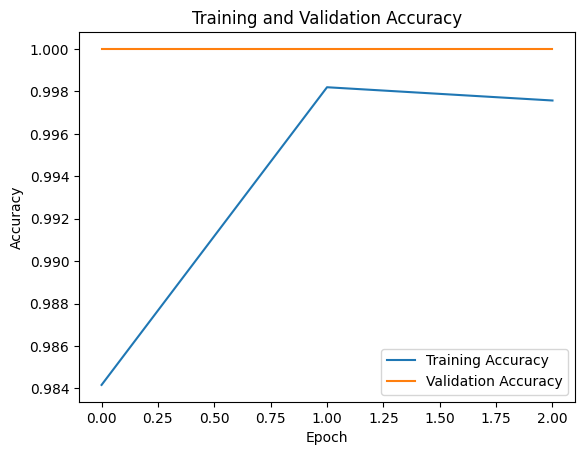

In [104]:
# Extrair métricas de precisão do histórico
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotar a precisão do treinamento e da validação ao longo das épocas
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


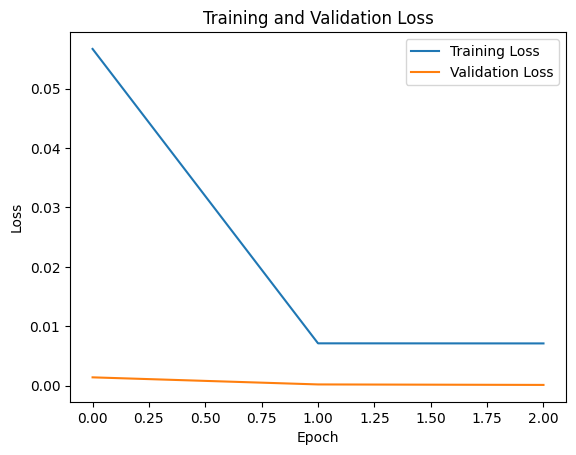

In [106]:
# Extrair métricas de perda do histórico
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotar as curvas de perda durante o treinamento e a validação
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# model.save('./CountFinger1.keras')